# Deep Vision Project by Fabian Schmidt
####  Who is allowed to enter the classroom: Contrastive Learning for face and signature recognition

<a id="0"></a>
 # Table of Contents
1. [Preparing the Dataset](#1)     
    - [Download Datasets](#1a)
    - [Define Custom Dataset class](#1b)
    - [Define Train-Test-Split](#1c)
    - [Print positive and negative Sample](#1d)
2. [Define Model](#2)


## Preparing the Dataset<a class="anchor" id="1"></a>

#### Download UTKFace and signature-verification Dataset<a class="anchor" id="1a">

In [ ]:
import opendatasets as od 
import pandas 

#!wget https://hydranets-data.s3.eu-west-3.amazonaws.com/UTKFace.zip
#!unzip UTKFace.zip -d data && rm UTKFace.zip
#!rm -rf __MACOSX/
#!rm -rf data/__MACOSX

  
od.download("https://www.kaggle.com/datasets/mallapraveen/signature-matching/data") 

!mv signature-matching/custom signature
!rmdir signature-matching/
!mv signature data

In [ ]:
!unzip data/att.zip

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.Image 

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

#### Define Custom Dataset classes<a class="anchor" id="1b">

##### Face Dataset<a class="anchor" id="1b">

In [2]:
class FaceNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #Look until the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look until a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [3]:
# Load the training dataset
face_train_folder_dataset = datasets.ImageFolder(root="./data/faces/training/")
face_test_folder_dataset = datasets.ImageFolder(root="./data/faces/testing/")


# Resize the images and transform to tensors
# Define the transformations including augmentations
transformation = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(100, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


# Initialize the network
face_train_dataset = FaceNetworkDataset(imageFolderDataset=face_train_folder_dataset, transform=transformation)

train_size = int(0.8 * len(face_train_dataset))
valid_size = len(face_train_dataset) - train_size
face_train_dataset, face_valid_dataset = torch.utils.data.random_split(face_train_dataset, [train_size, valid_size])

face_test_dataset = FaceNetworkDataset(imageFolderDataset=face_test_folder_dataset, transform=transformation)

print(f"Number of training samples: {len(face_train_dataset)}")
print(f"Number of validation samples: {len(face_valid_dataset)}")
print(f"Number of testing samples: {len(face_test_dataset)}")


Number of training samples: 296
Number of validation samples: 74
Number of testing samples: 30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


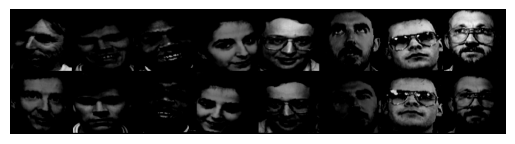

[1. 0. 0. 0. 0. 0. 0. 0.]


In [4]:
# Create a dataloader just visualization
vis_dataloader = DataLoader(face_valid_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

##### Signature Dataset<a class="anchor" id="1b">

In [5]:
import pandas as pd
import os
import PIL
class SignatureNetworkDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):        
        self.transform = transform
        self.root_dir = root_dir
        self.data = df

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img0_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        img1_name = os.path.join(self.root_dir, self.data.iloc[idx, 1])
        image0 = Image.open(img0_name)
        image1 = Image.open(img1_name)
        
        image0 = image0.convert("L")
        image1 = image1.convert("L")

        if self.transform:
            image0 = self.transform(image0)
            image1 = self.transform(image1)

        return image0, image1, torch.from_numpy(np.array([int(self.data.iloc[idx, 2])], dtype=np.float32))
        
    def __len__(self):
        return len(self.data)

In [20]:
from sklearn.model_selection import train_test_split
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")

signature_train_csv = "./data/signature/train_data.csv"
signature_test_csv = "./data/signature/test_data.csv"
signature_image_dir = "./data/signature/full"

# Resize the images and transform to tensors
# Define the transformations including augmentations
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5],std=[0.5])
                                    ])

signature_train_df = pd.read_csv(signature_train_csv)
signature_test_df = pd.read_csv(signature_test_csv)
train_df, valid_df = train_test_split(signature_train_df, test_size=0.2,random_state = 42)

signature_train_dataset = SignatureNetworkDataset(df=train_df, root_dir=signature_image_dir, transform=transformation)
signature_valid_dataset = SignatureNetworkDataset(df=valid_df, root_dir=signature_image_dir, transform=transformation)
signature_test_dataset = SignatureNetworkDataset(df=signature_test_df, root_dir=signature_image_dir, transform=transformation)

print(f"Number of training samples: {len(signature_train_dataset)}")
print(f"Number of validation samples: {len(signature_valid_dataset)}")
print(f"Number of testing samples: {len(signature_test_dataset)}")

Number of training samples: 61376
Number of validation samples: 15345
Number of testing samples: 8525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.67058825..1.0].


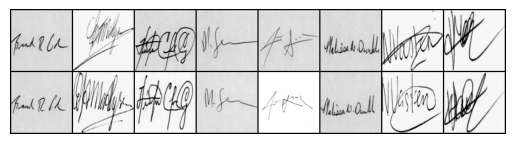

[1. 0. 0. 1. 0. 1. 0. 1.]


In [21]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(signature_train_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

[Back to the top](#0) 

## Define Model<a class="anchor" id="2">

In [8]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=5.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
      # label = 1 means different people, label = 0 means same people  
      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

Epoch number 0
 Current loss 8.664636611938477

Validation loss after 10 iterations: 9.103245735168457

Epoch number 1
 Current loss 8.183548927307129

Validation loss after 20 iterations: 13.43835163116455

Epoch number 2
 Current loss 7.286815166473389

Validation loss after 30 iterations: 13.72579288482666

Epoch number 3
 Current loss 7.257508277893066

Validation loss after 40 iterations: 10.929112434387207

Epoch number 4
 Current loss 7.381740570068359

Validation loss after 50 iterations: 12.041001319885254

Epoch number 5
 Current loss 7.494391441345215

Validation loss after 60 iterations: 11.2857084274292

Epoch number 6
 Current loss 7.729976654052734

Validation loss after 70 iterations: 10.36436939239502

Epoch number 7
 Current loss 7.089992523193359

Validation loss after 80 iterations: 9.02686595916748

Epoch number 8
 Current loss 6.896076679229736

Validation loss after 90 iterations: 8.520219802856445

Epoch number 9
 Current loss 7.099522113800049

Validation loss 

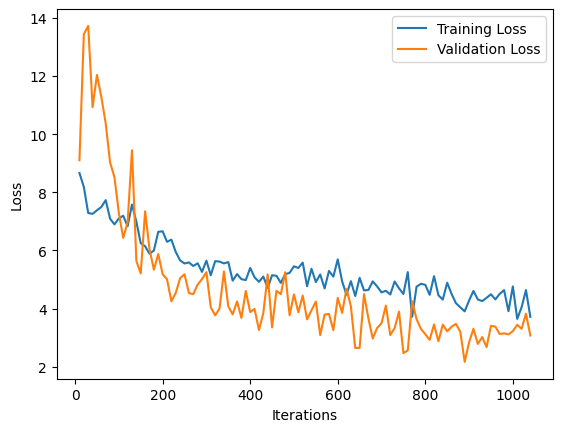

In [9]:
import SiameseFaceNetwork
# Load the training dataset
face_train_loader = DataLoader(face_train_dataset, shuffle=True, num_workers=8, batch_size=256)
face_valid_loader = DataLoader(face_valid_dataset, shuffle=True, num_workers=8, batch_size=256)
face_test_loader = DataLoader(face_test_dataset, shuffle=True, num_workers=8, batch_size=256)

face_net = SiameseFaceNetwork.SiameseFaceNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(face_net.parameters(), lr = 0.0001 )
face_net.train_network(train_loader = face_train_loader, val_loader = face_valid_loader, net = face_net, optimizer = optimizer, criterion = criterion, epochs = 200, patience=15)


In [10]:

torch.save(face_net.state_dict(), 'checkpoints/face_net.pt')




In [11]:
import MultitaskSignatureNet

signature_train_loader = DataLoader(signature_train_dataset, shuffle=True, num_workers=8, batch_size=1024)
signature_valid_loader = DataLoader(signature_valid_dataset, shuffle=True, num_workers=8, batch_size=1024)

signature_net = MultitaskSignatureNet.SiameseSignatureNetwork().cuda()
criterion = ContrastiveLoss()

optimizer = optim.Adam(signature_net.parameters(), lr = 0.0001)
signature_net.train_network(signature_train_loader, signature_valid_loader, signature_net, optimizer, criterion, epochs=100, patience=15)

Epoch number 0
 Current loss 8.499544143676758

Validation loss after 10 iterations: 12.47712999979655

Epoch number 0
 Current loss 12.747391700744629

Validation loss after 20 iterations: 12.23144334157308

Epoch number 0
 Current loss 12.450241088867188

Validation loss after 30 iterations: 11.676097043355306

Epoch number 0
 Current loss 10.299362182617188

Validation loss after 40 iterations: 9.792661666870117

Epoch number 0
 Current loss 8.532452583312988

Validation loss after 50 iterations: 8.639973354339599

Epoch number 0
 Current loss 8.470643997192383

Validation loss after 60 iterations: 8.577096684773762

Epoch number 1
 Current loss 10.63100814819336

Validation loss after 70 iterations: 8.867334493001302

Epoch number 1
 Current loss 8.431234359741211

Validation loss after 80 iterations: 8.544145329793293

Epoch number 1
 Current loss 8.501121520996094

Validation loss after 90 iterations: 8.570302454630534

Epoch number 1
 Current loss 8.613811492919922

Validation l

KeyboardInterrupt: 

In [12]:
torch.save(signature_net.state_dict(), 'checkpoints/signature_net.pt')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


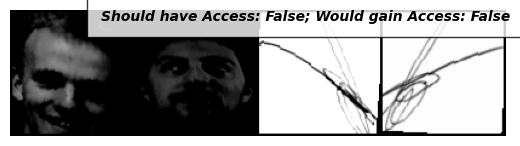

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


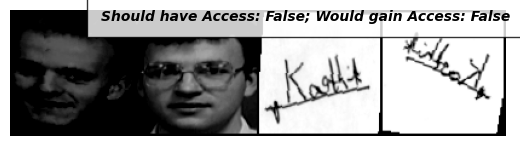

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


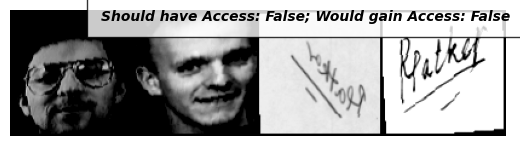

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].


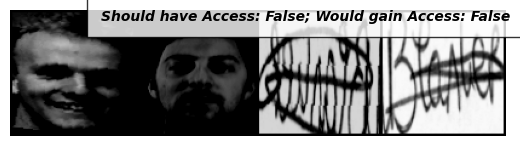

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


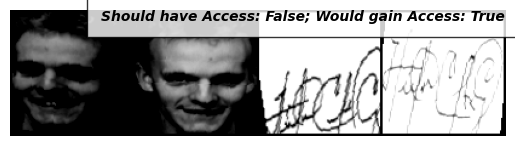

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


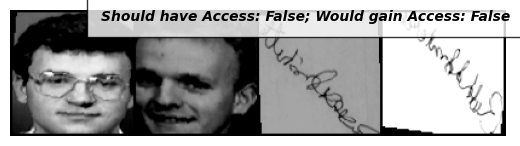

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


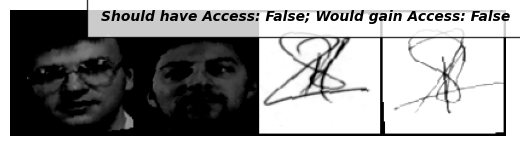

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


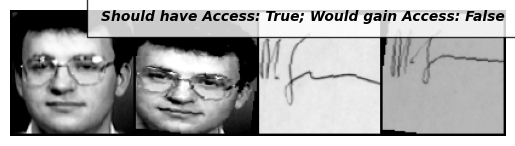

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


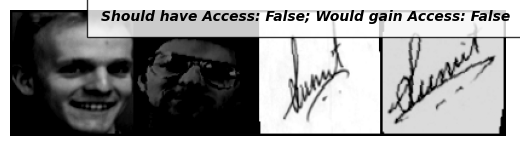

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7490196].


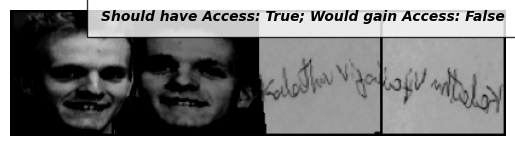

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


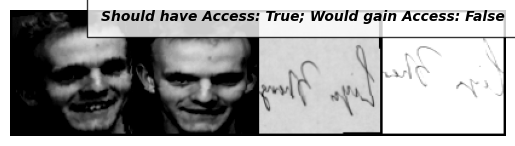

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].


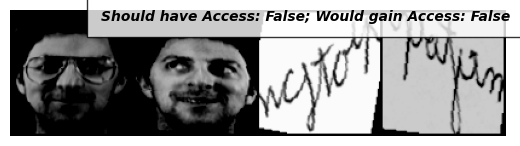

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8666667].


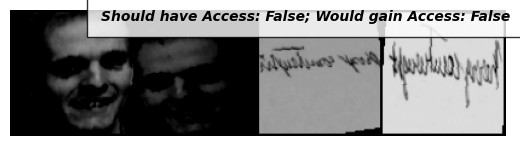

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].


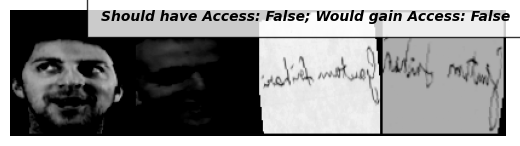

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


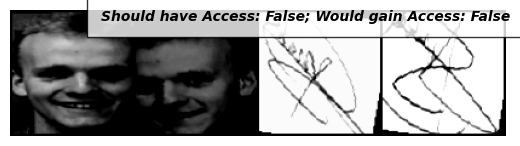

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].


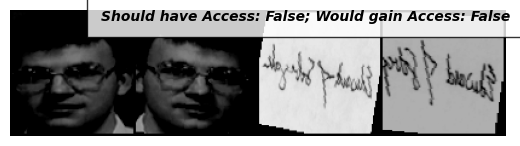

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


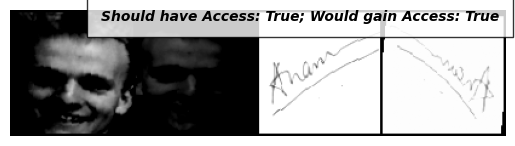

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


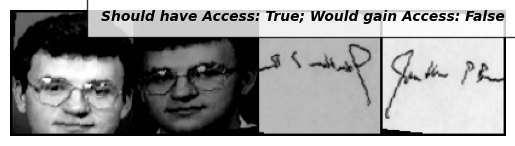

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].


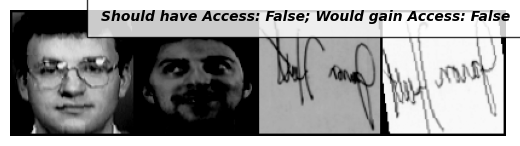

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


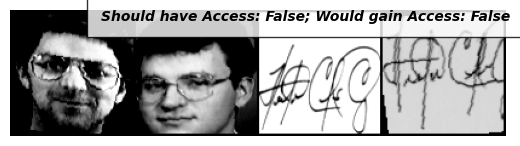

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


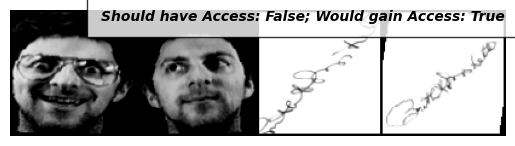

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


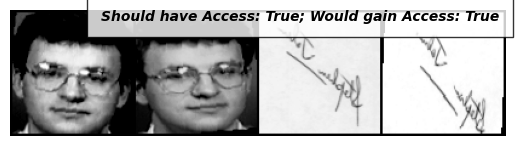

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


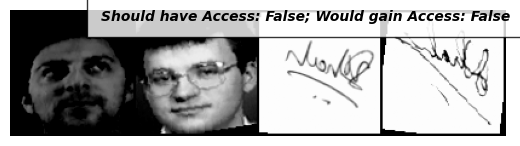

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.827451].


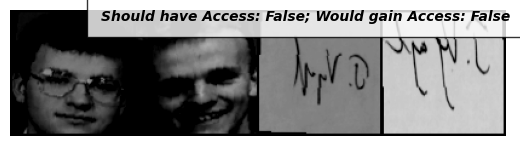

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


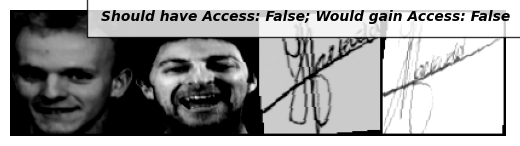

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


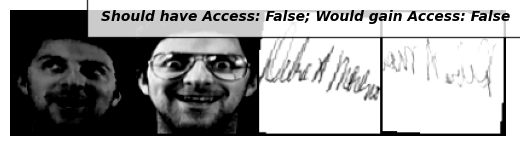

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.94509804].


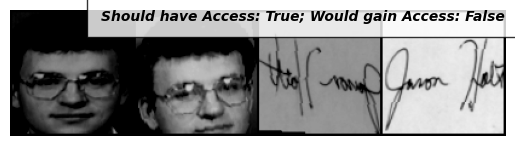

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


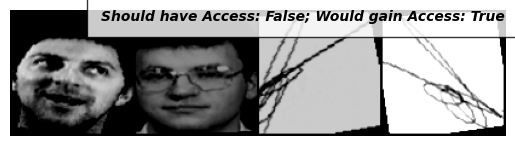

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].


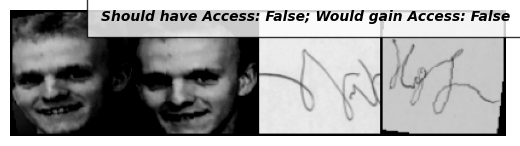

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].


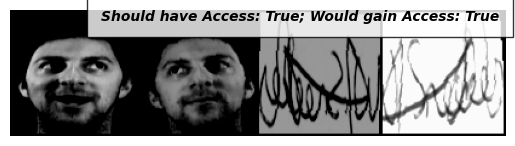

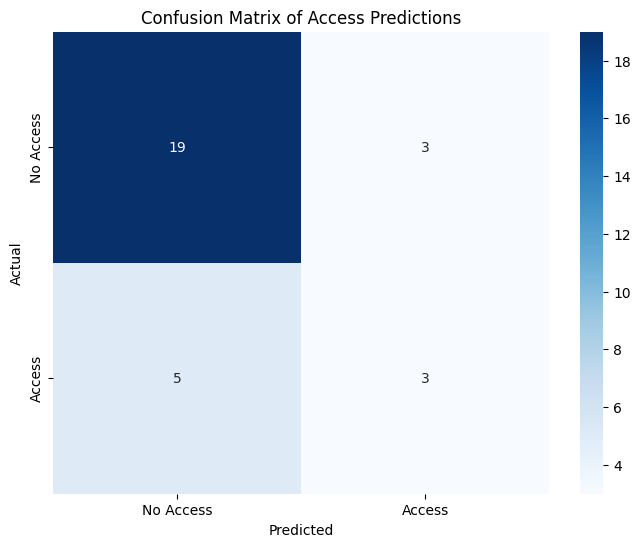

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
face_test_dataset = FaceNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
face_test_dataloader = DataLoader(face_test_dataset, num_workers=2, batch_size=1, shuffle=True)
signature_test_loader = DataLoader(signature_test_dataset, shuffle=True, num_workers=2, batch_size=1)

# Grab one image that we are going to test
face_dataiter = iter(face_test_dataloader)
signature_dataiter = iter(signature_test_loader)

should_have_access_list = []
would_gain_access_list = []

for i in range(30):
    # Iterate over 5 images and test them with the first image (x0)
    face0, face1, face_label = next(face_dataiter)
    signature1, signature2, forge_label = next(signature_dataiter)

    face_output1, face_output2 = face_net(face0.cuda(), face1.cuda())
    euclidean_distance = F.pairwise_distance(face_output1, face_output2)
    face_distance = (euclidean_distance < 3).bool()

    signature_output1, signature_output2 = signature_net(signature1.cuda(), signature2.cuda())
    euclidean_distance = F.pairwise_distance(signature_output1, signature_output2)
    signature_distance = (euclidean_distance < 2).bool()
    
    # Concatenate the two images together
    concatenated = torch.cat((face0, face1, signature1, signature2), 0)
    would_gain_access = face_distance.cpu()[0] and signature_distance.cpu()[0]
    should_have_access = not face_label.cpu()[0][0].bool() and forge_label.cpu()[0][0].bool()
    should_have_access_list.append(should_have_access)
    would_gain_access_list.append(would_gain_access)
    
    imshow(torchvision.utils.make_grid(concatenated), f'Should have Access: {should_have_access}; Would gain Access: {would_gain_access}')


# Create confusion matrix
conf_matrix = confusion_matrix(should_have_access_list, would_gain_access_list)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Access', 'Access'], yticklabels=['No Access', 'Access'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Access Predictions')
plt.show()